In [17]:
# Imports
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from itertools import combinations, groupby
import random

In [18]:
def get_d(A):
    # Diagonal degree matrix of A
    D = np.diag(np.sum(A, axis=0))
    return D

In [19]:
def get_p(A, D):
    # Transition probability matrix from scaling all adjacencies with 1/degree
    P = np.matmul(np.linalg.inv(D), A)
    return P

In [20]:
def get_g(A):
    # Create networkx graph from adjacency matrix
    G = nx.from_numpy_matrix(A, parallel_edges=True, create_using=nx.MultiGraph())
    return G

In [21]:
def calculate_pi(P):
    # approximate stationary distribution of Markov Chain
    return [round(x, 3) for x in list(np.linalg.matrix_power(P, 10000)[0])]

In [22]:
def graph_rw_sim(nsim, n, P, G, from_pi=False):
    # nsim different random walks of length n on G
    all_walks = []
    ps = P.shape[0]
    if from_pi == True:
        pi = calculate_pi(P)
    
    for _ in range(nsim):
        walk = np.zeros(n+1)
        if from_pi == False:
            v0 = np.random.choice(sorted(G.nodes()), p=[.25, .25, .25, .25])
        else:
            v0 = np.random.choice(sorted(G.nodes()), p=pi)
            
        walk[0] = v0

        current = v0-1
        for k in range(1, n+1):
            vk = np.random.choice(range(ps), 1, p=P[current])
            current = vk[0]
            walk[k] = current+1
    
        all_walks.append(walk)

    simulation_data = pd.DataFrame(all_walks).T
    return simulation_data

In [23]:
def plot_graph_rw_sim(data):
    colors = ['lightcoral', 'plum', 'cornflowerblue']
    for i in range(len(data.columns)):
        plt.figure(figsize = (10, 5))
        plt.plot(data[i], color = colors[i])
        plt.title('50-Step Random Walk on Good Will Hunting Graph ' + str(i+1))
        plt.xlabel('discrete time-step')
        plt.ylabel('unique vertices visited')
        plt.yticks([1,2,3,4])
        filename = ('png_data/rw_sim_graph' + str(i+1) + '.png')
        plt.savefig(filename, dpi = 300)
        plt.show()

In [24]:
def graph_rw_cover_time_sim(nsim, P, G, from_pi=False):
    # nsim cover times for random walk on G
    node_set = set(sorted(G.nodes()))
    all_cover_times = []
    ps = P.shape[0]
    if from_pi == True:
        pi = calculate_pi(P)

    for _ in range(nsim):
        if from_pi == False:
            v0 = np.random.choice(sorted(G.nodes()), p=[.25, .25, .25, .25])
        else:
            v0 = np.random.choice(sorted(G.nodes()), p=pi)
        
        current = v0-1
        done = False
        visited = [v0]
        k = 0
        while not done:
            vk = np.random.choice(range(ps), 1, p=P[current])
            current = vk[0]
            visited.append(current+1)

            if(node_set == set(sorted(visited))):
                done = True
            else:
                k+=1
    
        all_cover_times.append(k)
    
    return all_cover_times

In [25]:
def expected_cover_time_mc(data):
    # expected cover time based on Monte Carlo
    return np.mean(data)

In [26]:
def simple_update(k, pos, G, ax, rw_realization):
    # used for making a gif of a single random walk realization
    ax.clear()

    nx.draw_networkx(G, pos=pos, with_labels=True)
    nx.draw_networkx(G.subgraph(rw_realization[k]), pos=pos, node_color="red")
    
    ax.set_title("Time-step %d" % k)

In [27]:
def gnp_random_connected_graph(n, p):
    # Generate random undirected connected graph
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

In [28]:
def expected_cover_time_barplot(d):
    exp_cover_times = [x[1] for x in d.values()]
    plt.figure(figsize=(10, 5))
    plt.bar(d.keys(), exp_cover_times, color = ['pink', 'thistle', 'powderblue', 'salmon', 'bisque', 'plum', 'lightsteelblue', 'palevioletred'])
    plt.title('Barplot of Expected Cover Times')
    plt.xlabel('graph type')
    plt.ylabel('expected cover time')
    plt.savefig('png_data/cover_time_barplot.png', dpi = 300)
    plt.show()

In [29]:
def cover_time_histograms(d):
    cover_time_data = [x[0] for x in d.values()]
    colors = ['pink', 'thistle', 'powderblue', 'salmon', 'bisque', 'plum', 'lightsteelblue', 'palevioletred']
    for i, key in enumerate(d.keys()):
        plt.figure(figsize=(10, 5))
        plt.hist(cover_time_data[i], bins=20, color=colors[i])
        plt.title("Histogram of Cover Times for " + key + " Graph")
        plt.xlabel("cover time bin")
        plt.ylabel("frequency")
        plt.savefig("png_data/cover_time_hist_" + key + ".png", dpi = 300)
        plt.show()

In [30]:
def modified_graph_rw_sim(nsim, n, P, G, from_pi=False):
    ### MODIFIED TO KEEP TRACK OF UNIQUE NODES VISITED ###
    node_set = set(sorted(G.nodes()))
    # nsim different random walks of length n on G
    all_walks = []
    ps = P.shape[0]
    if from_pi == True:
        pi = calculate_pi(P)
    
    for _ in range(nsim):
        walk = np.zeros(n+1)
        if from_pi == False:
            v0 = np.random.choice(sorted(G.nodes()), p=[.25, .25, .25, .25])
        else:
            v0 = np.random.choice(sorted(G.nodes()), p=pi)

        current = v0-1
        visited = [v0]
        walk[0] = len(set(sorted(visited)))
        for k in range(1, n+1):
            vk = np.random.choice(range(ps), 1, p=P[current])
            current = vk[0]
            visited.append(current+1)
            walk[k] = len(set(sorted(visited)))
    
        all_walks.append(walk)

    simulation_data = pd.DataFrame(all_walks).T
    return simulation_data

In [31]:
def main():
    # Good Will Hunting problem adjacency matrix
    A = np.array([[0, 1, 0, 1], #1
                [1, 0, 2, 1], #2
                [0, 2, 0, 0], #3
                [1, 1, 0, 0]]) #4
    
    D = get_d(A)
    P = get_p(A, D)
    G = get_g(A)
    
    # Relabel vertices in accordance with paper
    mapping = {3:1, 0:4, 1:2, 2:3}
    G = nx.relabel_nodes(G, mapping)

    # Simulate 3 random walks of length 50
    NWALKS = 3
    WALKLEN = 25
    data = modified_graph_rw_sim(NWALKS, WALKLEN, P, G, from_pi=False).astype(int)
    plot_graph_rw_sim(data)

    # Animate and save the random walk realizations
    pos = nx.spring_layout(G)
    figure, axes = plt.subplots(figsize=(10, 10))
    
    for i, col in enumerate(data.columns):
        ani = animation.FuncAnimation(figure, simple_update, frames=WALKLEN+1, fargs=(pos, G, axes, data[col]))
        ani.save("./rw_animation_data/rw_realization" + str(i+1) + ".gif", writer="Pillow", dpi = 300)

    # Cover time simulations
    # First use Good Will Hunting graph with random uniform start and random stationary start
    # Then more cover time simulations with other graphs of size 4 and different structures to analyze relative cover times
    all_cover_time_data = {}
    NSIM=2500
    
    G_complete = nx.complete_graph(4)
    G_lollipop = nx.lollipop_graph(3, 1)
    G_star = nx.star_graph(3)
    G_tree = nx.random_tree(4)
    G_regular = nx.random_regular_graph(2, 4)
    G_random = gnp_random_connected_graph(4, .5)

    all_graphs = {"GWH":G, "GWH pi":G, "Complete":G_complete, "Lollipop":G_lollipop, "Star":G_star, "Tree":G_tree, "Regular":G_regular, "Random":G_random}
    for key in all_graphs.keys():
        if key != "GWH" and key != "GWH pi":
            all_graphs[key] = nx.convert_node_labels_to_integers(all_graphs[key], 1)
        
        A_rand = np.array(nx.adjacency_matrix(all_graphs[key]).todense())
        D_rand = get_d(A_rand)
        P_rand = get_p(A_rand, D_rand)
        if key != "GWH pi":
            rand_cover_time_data = graph_rw_cover_time_sim(NSIM, P_rand, all_graphs[key], from_pi=False)
        else:
            rand_cover_time_data = graph_rw_cover_time_sim(NSIM, P_rand, all_graphs[key], from_pi=True)
        rand_expected_cover_time = expected_cover_time_mc(rand_cover_time_data)
        all_cover_time_data[key] = [rand_cover_time_data, rand_expected_cover_time]
    
    # Plot barplot of cover times
    expected_cover_time_barplot(all_cover_time_data)

    # Plot cover time histograms for all graphs
    cover_time_histograms(all_cover_time_data)

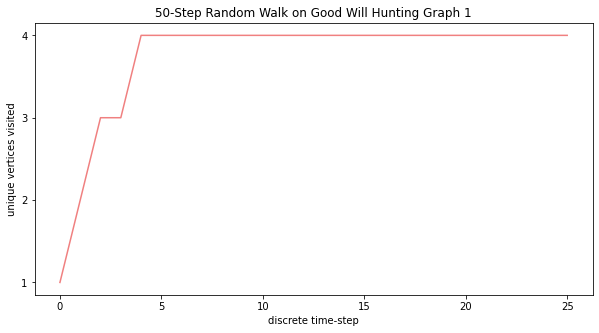

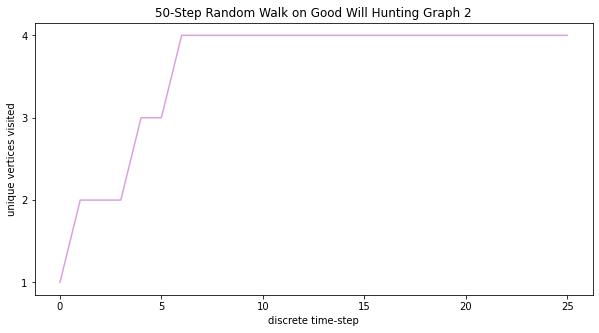

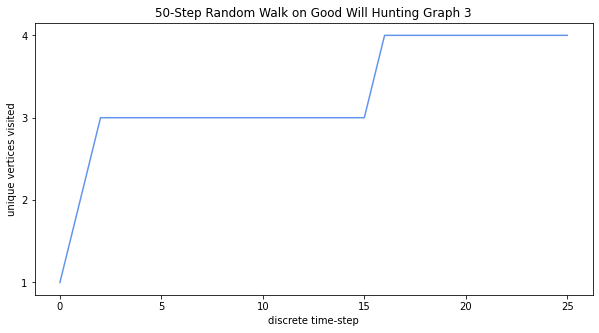

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


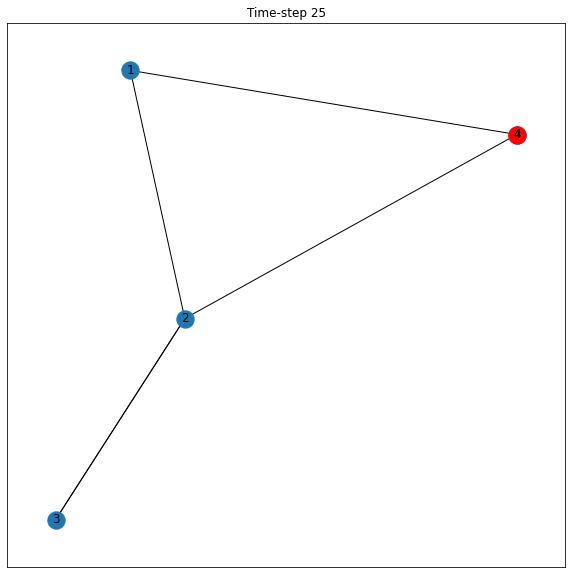

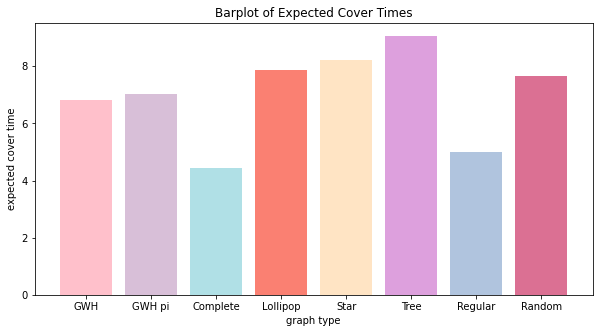

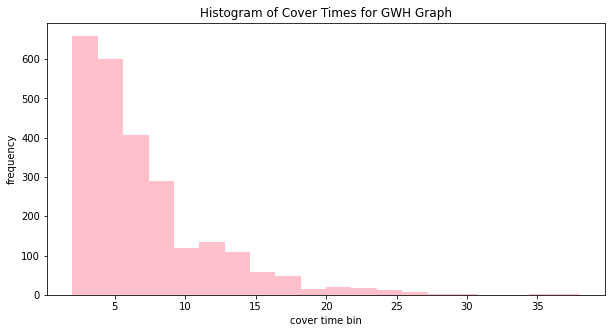

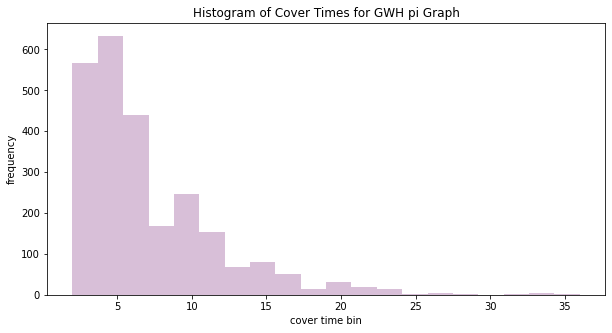

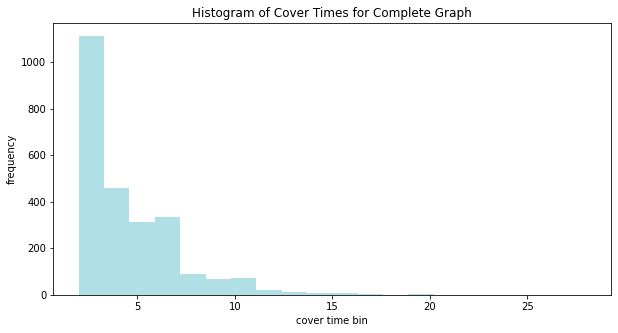

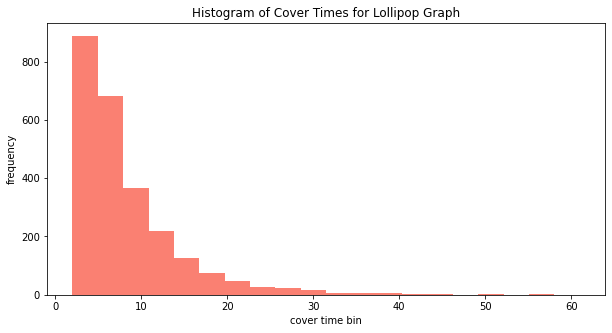

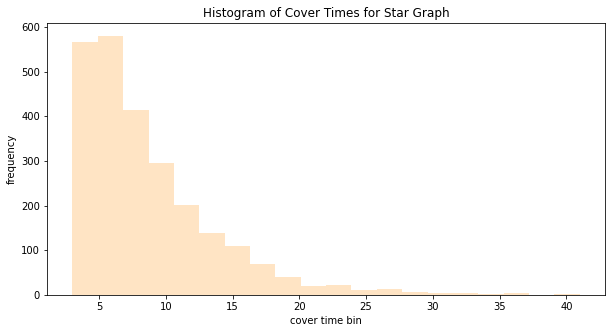

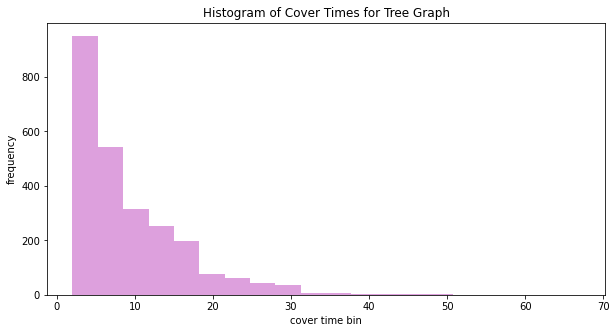

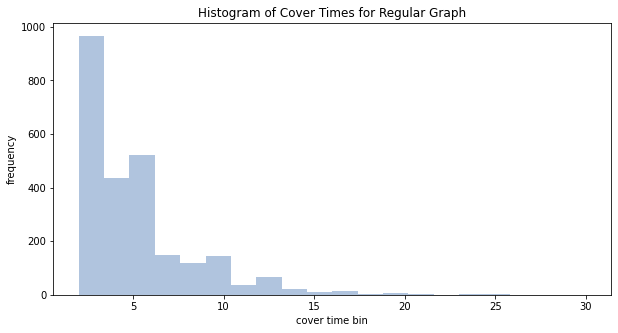

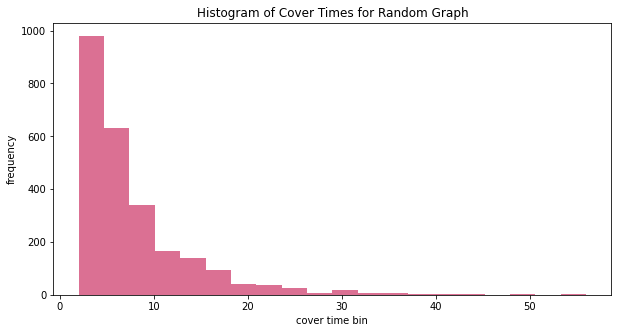

In [32]:
if __name__ == "__main__":
    main()